In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
dir_github = '/media/rich/Home_Linux_partition/github_repos/'
import sys
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [3]:
###################################
# Reading Videos Using Torchvision
# --------------------------------
# We will first read a video using :func:`~torchvision.io.read_video`.
# Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
# torchvision is built from source).
# The video we will use here is free of use from `pexels.com
# <https://www.pexels.com/video/a-man-playing-a-game-of-basketball-5192157/>`_,
# credits go to `Pavel Danilyuk <https://www.pexels.com/@pavel-danilyuk>`_.


import tempfile
from pathlib import Path
from urllib.request import urlretrieve


# video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
# video_path = Path(tempfile.mkdtemp()) / "basketball.mp4"
# _ = urlretrieve(video_url, video_path)

path_video = str(Path('/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment/cam32021-04-18T00_41_02.avi').resolve())

In [4]:
import decord
vid = decord.VideoReader(path_video, ctx=decord.cpu())

In [5]:
import torch
import torchvision
# frames = torch.as_tensor(vid[:200].asnumpy()).permute(0,3,1,2)
# img1_batch_raw = frames[0:20]
# img2_batch_raw = frames[1:21]

In [6]:
####################################
# Estimating Optical flow using RAFT
# ----------------------------------
# We will use our RAFT implementation from
# :func:`~torchvision.models.optical_flow.raft_large`, which follows the same
# architecture as the one described in the `original paper <https://arxiv.org/abs/2003.12039>`_.
# We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
# builder, which is smaller and faster to run, sacrificing a bit of accuracy.

from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device_model = "cuda" if torch.cuda.is_available() else "cpu"
device_preprocess = 'cpu'

model = raft_large(pretrained=True, progress=False).to(device_model)
model = model.eval()

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#########################
# The RAFT model that we will use accepts RGB float images with pixel values in
# [-1, 1]. The frames we got from :func:`~torchvision.io.read_video` are int
# images with values in [0, 255], so we will have to pre-process them. We also
# reduce the image sizes for the example to run faster. Image dimension must be
# divisible by 8.


def preprocess(batch):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ConvertImageDtype(torch.float32),
            torchvision.transforms.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
#             torchvision.transforms.Normalize(mean=[0,0,0], std=0.5),  # map [0, 1] into [-1, 1]
#             torchvision.transforms.Resize(size=(520, 960)),
#             torchvision.transforms.Resize(size=(304, 392)),
#             torchvision.transforms.Resize(size=(560, 800)),            
            torchvision.transforms.Resize(size=(608, 784)),            
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device_model = "cuda" if torch.cuda.is_available() else "cpu"
device_preprocess = 'cpu'

In [10]:
####################################
# Bonus: Creating GIFs of predicted flows
# ---------------------------------------
# In the example above we have only shown the predicted flows of 2 pairs of
# frames. A fun way to apply the Optical Flow models is to run the model on an
# entire video, and create a new video from all the predicted flows. Below is a
# snippet that can get you started with this. We comment out the code, because
# this example is being rendered on a machine without a GPU, and it would take
# too long to run it.

from torchvision.utils import flow_to_image

frames = torch.as_tensor(vid[8300:8400].asnumpy()).permute(0,3,1,2)
# imgs = preprocess(frames/255)
imgs = preprocess(frames)

ims = []

In [11]:
frames.min(), frames.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [12]:
imgs.min(), imgs.max()

(tensor(-1.), tensor(1.))

In [13]:
from torchvision.io import write_jpeg
from tqdm import tqdm
for i, (img1, img2) in tqdm(enumerate(zip(imgs[:-1], imgs[1:]))):
    # Note: it would be faster to predict batches of flows instead of individual flows
    list_of_flows = model(img1[None,...].to(device_model), img2[None,...].to(device_model))
    predicted_flow = list_of_flows[-1][0].to('cpu')
    
    ims.append(predicted_flow)
#     break

99it [00:07, 13.11it/s]


In [14]:
ims_all = torch.stack(ims)

In [457]:
ims_all_conv = timeSeries.convolve_torch(ims_all, torch.ones(3))

In [15]:
flow_ims = flow_to_image(ims_all)

In [458]:
flow_ims = flow_to_image(ims_all_conv)

In [433]:
frames.shape

torch.Size([333, 3, 720, 1280])

In [453]:
imgs.shape

torch.Size([200, 3, 520, 960])

In [57]:
image_processing.play_video_cv2(array=flow_ims.permute(0,2,3,1).numpy(), frameRate=20)
    
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

  0%|          | 0/99 [00:00<?, ?it/s]

In [24]:
image_processing.play_video_cv2(array=((ims_all[:,1,...] +5)*10).permute(0,1,2).numpy(), frameRate=20)
    
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

  0%|          | 0/99 [00:00<?, ?it/s]

In [628]:
image_processing.play_video_cv2(array=frames.permute(0,2,3,1).numpy(), frameRate=20)
    
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

  0%|          | 0/600 [00:00<?, ?it/s]

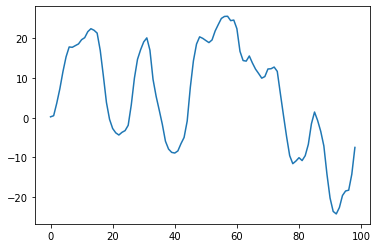

In [23]:
plt.figure()
plt.plot(np.cumsum(ims_all[:,1,170,658]))

In [25]:
ims_all.shape

torch.Size([99, 2, 608, 784])

In [18]:
import copy

In [39]:
ff.dtype

torch.float32

In [41]:
pt_starting = torch.tensor([300,300], dtype=torch.float32)

pt_current = copy.copy(pt_starting)
pos = [pt_starting]
for ii, ff in tqdm(enumerate(ims_all)):
    pt_current = pt_current + ff[:, int(pt_current[0]), int(pt_current[1])]
    pos.append(pt_current)

99it [00:00, 84141.05it/s]


In [47]:
pos_arr = torch.stack(pos)

In [48]:
pos_arr.shape

torch.Size([100, 2])

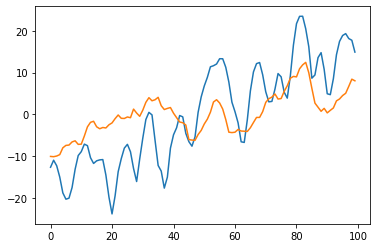

In [49]:
plt.figure()
plt.plot(pos_arr - pos_arr.mean(0))

In [302]:
frames.shape

torch.Size([20, 3, 610, 784])

In [587]:
frames.shape

torch.Size([100, 3, 610, 784])

In [314]:
frames.shape

torch.Size([20, 3, 610, 784])

In [331]:
imgs = preprocess(frames/255)

In [332]:
imgs.min()

tensor(-1.)

In [333]:
imgs.max()

tensor(1.)

In [309]:
torch.mean(imgs)

tensor(91.7186)

In [206]:
imgs.shape

torch.Size([20, 3, 520, 960])

In [186]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(imgs[0].reshape(-1), 100)

Error in callback <function flush_figures at 0x7f51981f10d0> (for post_execute):



KeyboardInterrupt


KeyboardInterrupt



In [158]:
frames.min()

tensor(0.)

In [157]:
frames.max()

tensor(255.)

In [398]:
image_processing.play_video_cv2(array=(((imgs+1)/2)*255).permute(0,2,3,1).numpy(), frameRate=20)
    
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

  0%|          | 0/200 [00:00<?, ?it/s]

In [399]:
image_processing.play_video_cv2(array=frames.permute(0,2,3,1).numpy(), frameRate=20)
    
#     output_folder = "/tmp/"  # Update this to the folder of your choice
#     write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
####################################
# Once the .jpg flow images are saved, you can convert them into a video or a
# GIF using ffmpeg with e.g.:

ffmpeg -f image2 -framerate 30 -i predicted_flow_%d.jpg -loop -1 flow.gif